# Video Generation for Aerodactylus - The Maiden Flight

This notebook is used to generate video content for the The Maiden Fight using the tools provided in the `aeraudioviz` package.

In [1]:
from aeraudioviz.audio import Audio, AudioFeatures
from aeraudioviz.audio.feature_utils import add_random_noise_column, add_sine_wave_column, fade_in_between_times, fade_out_between_times, set_to_zero_between_times
from aeraudioviz.image import BaseImage, ImageModifiers
from aeraudioviz.video import VideoGenerator, ModifierMapping

## Load the Audio File

Here we create an instance of the `Audio` class based on the input audio file.

In [2]:
audio = Audio('Aerodactylus - Jetsam Dreams - 01 The Maiden Flight.wav')

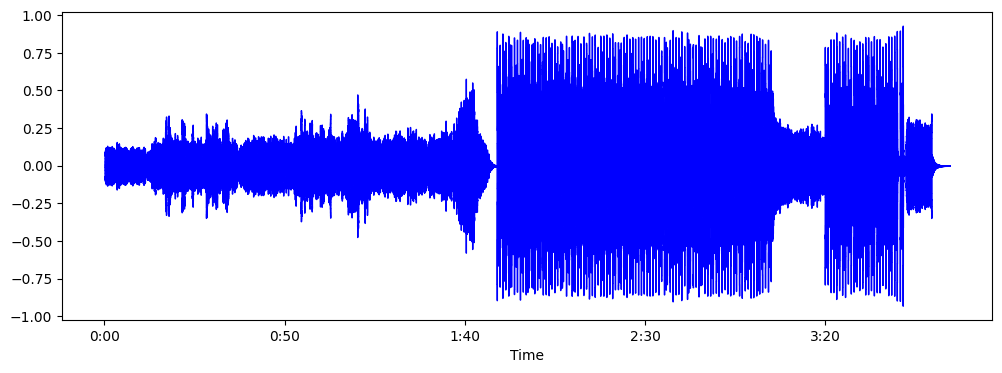

In [3]:
audio.plot_waveform()

## Extract Features from the Audio

Now we creat a `pandas.DataFrame` containing a time series of data features that will be used to manipulate the image in each frame of the video.

In [4]:
features = AudioFeatures(audio)

In [5]:
df = features.get_feature_time_series()

## Add Custom Features

Now we add some more custom features to the `DataFrame` that are not directly based on the audio data.

In [6]:
df = add_random_noise_column(df, column_name='Noise')

In [7]:
df = add_sine_wave_column(df, frequency_Hz=0.1, column_name='LFO Slow')
df = add_sine_wave_column(df, frequency_Hz=1., column_name='LFO Medium')
df = add_sine_wave_column(df, frequency_Hz=10., column_name='LFO Fast')

In [8]:
# Create a version of the LFO Medium column that is 0 outside of sections of the song with beats and multiply the signal by the Noise column 
df['Filtered Medium LFO'] = df['LFO Medium']
df.loc[df['Beats With Decay'].rolling(30).max().fillna(0.) < 0.1, 'Filtered Medium LFO'] = 0.
df['Filtered Medium LFO'] *= df['Noise']

## Modify existing columns

We want some effects to only be present during certain parts of the track so we can fade in or out certain signals during specific sections, or set the signal 0.

In [9]:
df = set_to_zero_between_times(df, 'Filtered Medium LFO', 184.875, audio.duration)

df = fade_out_between_times(df, 'Filtered Medium LFO', 134.125, 184.875, factor=.9)
df = fade_out_between_times(df, 'Filtered Medium LFO', 134.125, 184.875, factor=.9)

df = set_to_zero_between_times(df, 'Onset', 0., 38.4)
df = set_to_zero_between_times(df, 'Onset', 51.5, 108.75)

## Plot the Time Series Features

These resulting features will be used to drive the dynamic effects in the video we generate later.

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object)

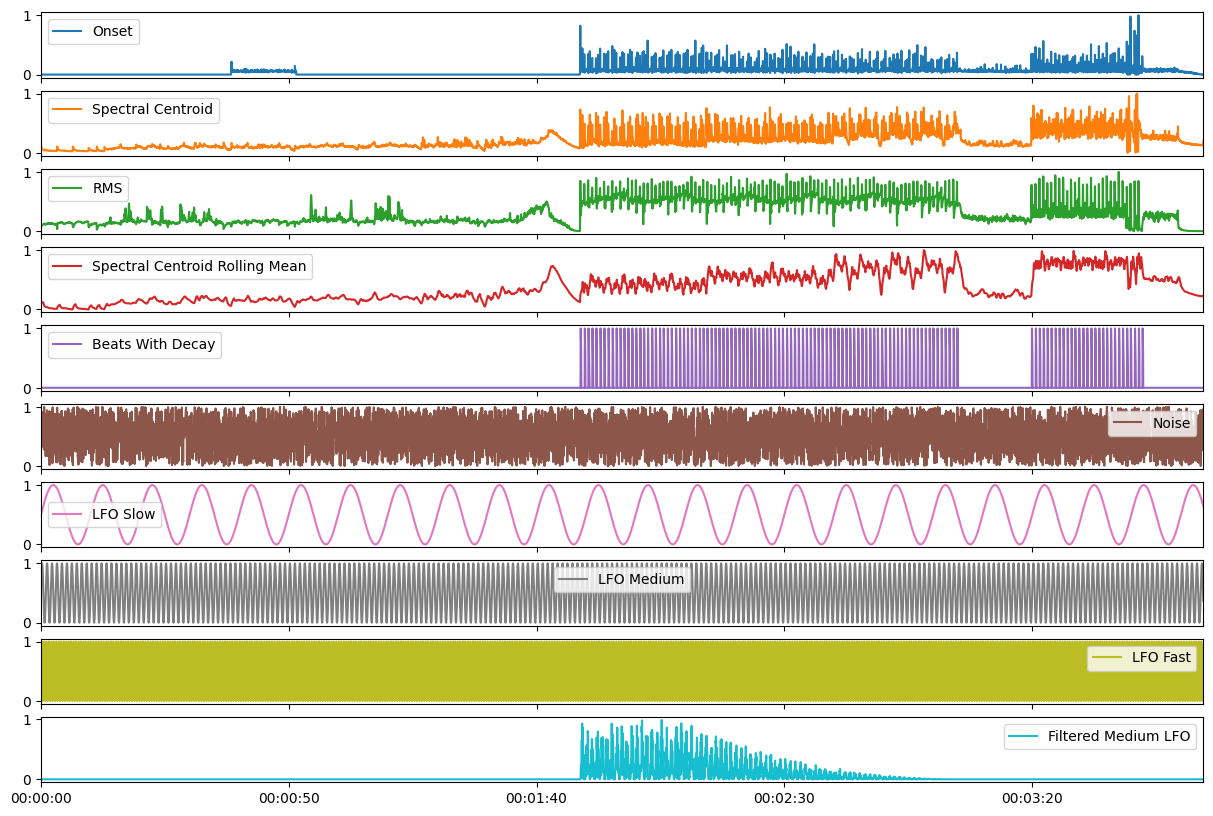

In [10]:
df.plot(subplots=True, figsize=(15, len(df.columns)))

## Load Base Image

The video will be generated by manipulating a base image based on the time series features generated previously. Here we load the base image.

In [11]:
image = BaseImage('cover.jpg')

Now show the image and the grayscale image, hue values, saturation values and values of the red, green and blue channels.

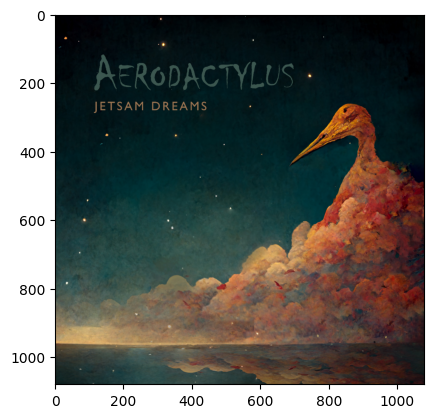

In [12]:
image.show()

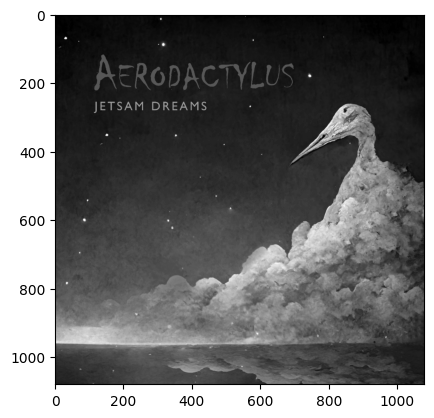

In [13]:
image.show_grayscale()

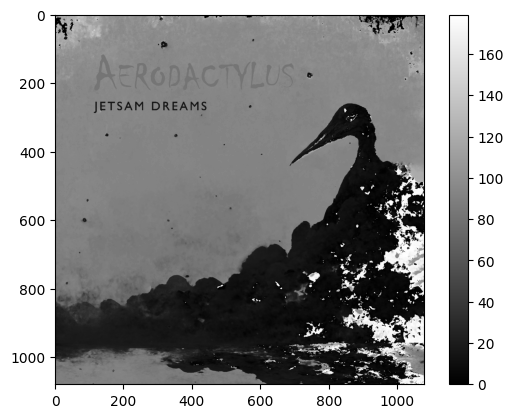

In [14]:
image.show_hue()

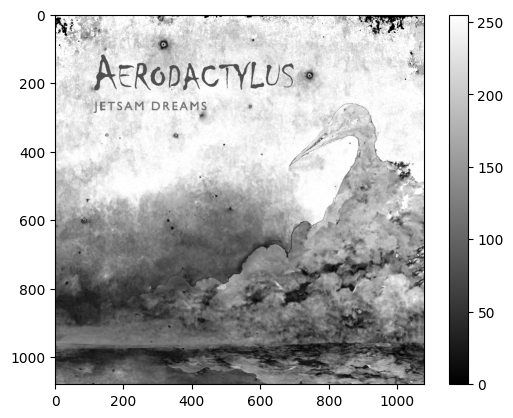

In [15]:
image.show_saturation()

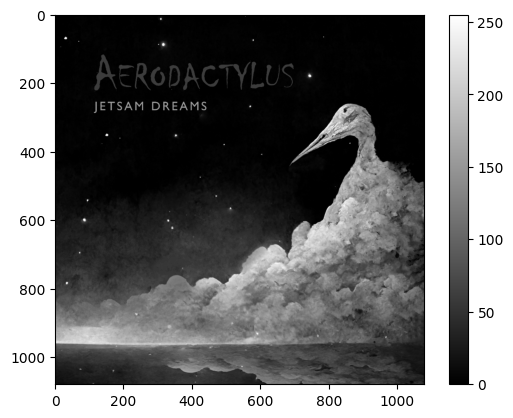

In [16]:
image.show_red_channel()

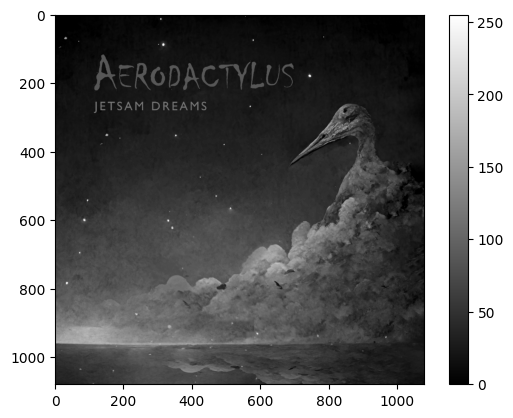

In [17]:
image.show_green_channel()

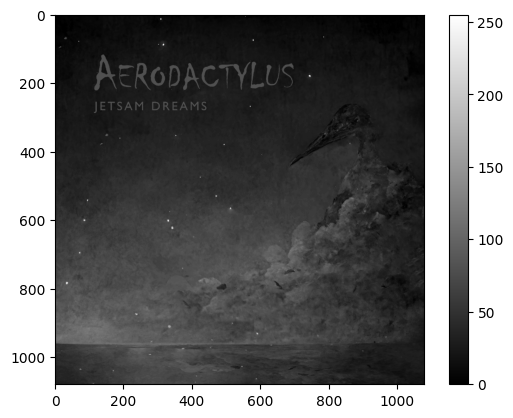

In [18]:
image.show_blue_channel()

## Define Mappings for Image Modification

We now define how the data columns in the time series features `DataFrame` are used to modify the image for each frame of the video.

Each `ModifierMapping` defines the following:
* `modifier_function`: the video effect function
* `modifier_column`: the data column from the time series `DataFrame` which is used to control the parameters of the `modifier_function` in each frame
* parameters: passed as `**kwargs` to the `ModifierMapping` class, key word argument name is the name of a parameter of the `modifier_function` and the value is a `tuple` defining the range of the values the function will take on at the min and max values of the data in the `modifier_column`.

In [19]:
modifier_mappings = (
    # use the "Spectral Centroid Rolling Mean" column to modify to the saturation
    # the value of "Spectral Centroid Rolling Mean" will be used to modify the "saturation_factor" parameter of the 
    # modifier function within the defined range
    ModifierMapping(
        modifier_function = ImageModifiers.apply_saturation_multiplication,
        modifier_column = 'Spectral Centroid Rolling Mean',
        saturation_factor = (.5, 1.75)
    ),

    # "Filtere Medium LFO" data will be used to apply a modification to the hue
    ModifierMapping(
        modifier_function = ImageModifiers.apply_hue_multiplication,
        modifier_column = 'Filtered Medium LFO',
        hue_factor = (1., 4.)
    ),

    # "Spectral Centroid" will be used to apply random black and white pixels, the "noise_ratio" parameter defines the fraction of pixels effected
    ModifierMapping(
        modifier_function = ImageModifiers.apply_salt_and_pepper_noise,
        modifier_column = 'Spectral Centroid',
        noise_ratio = (0., .0013)
    ),

    # "LFO Slow" will be used to increase the value of the blue channel in the image
    ModifierMapping(
        modifier_function = ImageModifiers.apply_rgb_multiplication,
        modifier_column = 'LFO Slow',
        blue_factor = (1., 1.75)
    ),

    # Gaussian noise will be applied to the image based on the value of "Spectral Centroid"
    ModifierMapping(
        modifier_function = ImageModifiers.apply_gaussian_noise,
        modifier_column = 'Spectral Centroid',
        standard_deviation = (0., .5)
    ),

    # Semi-transparent ghost images which are shifted relative to the initial will be overlayed
    # The number of images (controlled by "number_of_ghost_images" parameter) and their transparencey (controlled by "alpha") will be
    # controlled by the "Onset" data
    ModifierMapping(
        modifier_function = ImageModifiers.apply_ghost_images,
        modifier_column = 'Onset',
        number_of_ghost_images = (0, 9),
        alpha = (.1, .2)
    ),

    # Further saturation is applied based on the "Beats With Decay" column
    ModifierMapping(
        modifier_function = ImageModifiers.apply_saturation_multiplication,
        modifier_column = 'Beats With Decay',
        saturation_factor = (1., 1.75)
    ),
    
    # Finally, the image in each frame is blurred based on the value of the "Beats With Decay" data
    ModifierMapping(
        modifier_function = ImageModifiers.apply_gaussian_blur,
        modifier_column = 'Beats With Decay',
        kernel_size = (0, 15)
    )
)

## Generate Video

Now that we have defined the audio, base image, feature time series data, and modifier mappings we can proceed to generate the video.

In [20]:
video = VideoGenerator(
    base_image=image, 
    feature_time_series=df, 
    modifier_mappings=modifier_mappings,
    audio=audio
)

In [21]:
video.generate(audio.audio_path.split('.')[0] + '.mp4')

Generating video frames...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5630/5630 [17:06<00:00,  5.48it/s]


Frames generated.
Setting audio...
Audio set.
Writing video...
Moviepy - Building video Aerodactylus - Jetsam Dreams - 01 The Maiden Flight.mp4.
MoviePy - Writing audio in Aerodactylus - Jetsam Dreams - 01 The Maiden FlightTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video Aerodactylus - Jetsam Dreams - 01 The Maiden Flight.mp4



Moviepy - Done !
Moviepy - video ready Aerodactylus - Jetsam Dreams - 01 The Maiden Flight.mp4
Video written successfully to Aerodactylus - Jetsam Dreams - 01 The Maiden Flight.mp4.
